# Customer Satisfaction Prediction - Part 1: Exploratory Data Analysis
**Objective:** Understand dataset patterns through visualizations and statistical tests

In [11]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from wordcloud import WordCloud
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asshe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Data Loading & Initial Inspection

In [86]:
!pip install pickleshare
# Load data
df = pd.read_csv('customer_support_tickets.csv')
print(type(df), df.shape)
%store df 
# Basic info
print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'> (8469, 17)
Stored 'df' (DataFrame)
Dataset Shape: (8469, 17)

Missing Values:
Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64


C:\Python\Lib\site-packages\IPython\extensions\storemagic.py:229: UserWarning:

This is now an optional IPython functionality, setting autorestore/df requires you to install the `pickleshare` library.



In [4]:
# Display sample
df.head(3)

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,22-03-2021,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,01-06-2023 12:15,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,22-05-2021,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,01-06-2023 16:45,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,14-07-2020,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,01-06-2023 11:14,01-06-2023 18:05,3.0


In [87]:
print(df.columns)


Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')


## 2. Temporal Analysis

C:\Users\asshe\AppData\Local\Temp\ipykernel_21004\4167944226.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])


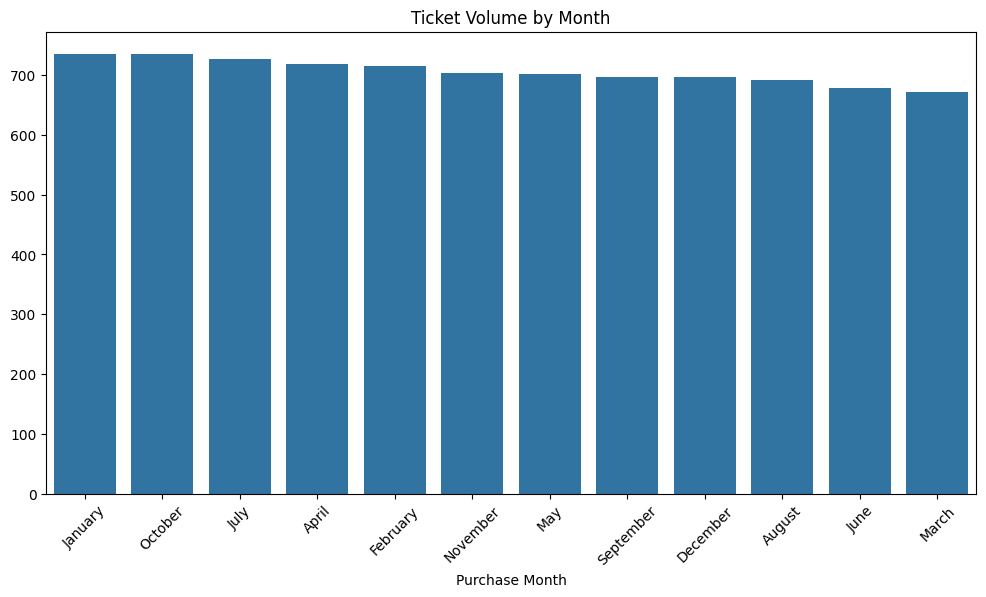

In [5]:
# Convert dates
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
df['Purchase Month'] = df['Date of Purchase'].dt.month_name()

# Monthly trends
plt.figure(figsize=(12,6))
monthly_counts = df['Purchase Month'].value_counts()
sns.barplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title("Ticket Volume by Month")
plt.xticks(rotation=45)
plt.show()


## 3. Statistical Tests

In [6]:
# ANOVA for Ticket Types
groups = [df[df['Ticket Type'] == t]['Customer Satisfaction Rating'].dropna() 
          for t in df['Ticket Type'].unique()]
f_stat, pval = f_oneway(*groups)
print(f"ANOVA p-value: {pval:.4f}") 

# Chi-square for Gender vs Product
contingency = pd.crosstab(df['Customer Gender'], df['Product Purchased'])
chi2, p, dof, _ = chi2_contingency(contingency)
print(f"\nChi-square p-value: {p:.4f}")


ANOVA p-value: 0.7008

Chi-square p-value: 0.9240


## 4. Text Sentiment Analysis

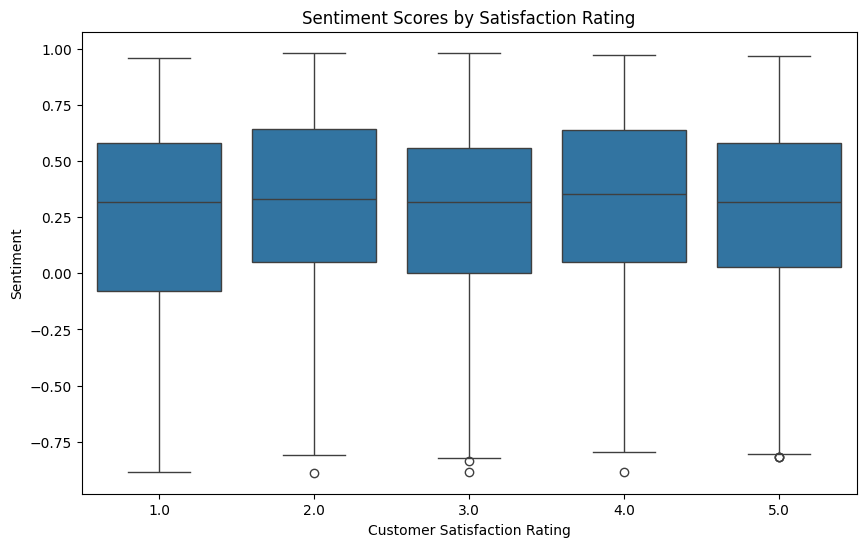

In [7]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Add sentiment scores
df['Sentiment'] = df['Ticket Description'].apply(
    lambda x: sia.polarity_scores(str(x))['compound'])

# Plot sentiment vs rating
plt.figure(figsize=(10,6))
sns.boxplot(x='Customer Satisfaction Rating', y='Sentiment', data=df)
plt.title("Sentiment Scores by Satisfaction Rating")
plt.show()

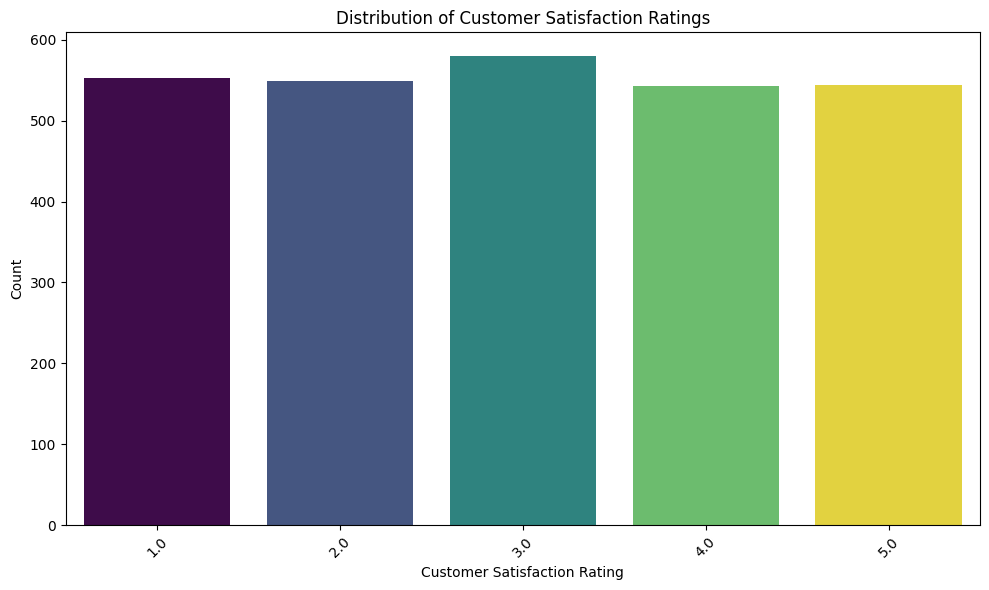

In [20]:
# Visualize satisfaction distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Customer Satisfaction Rating', hue='Customer Satisfaction Rating', data=df, palette='viridis', legend=False)
plt.title('Distribution of Customer Satisfaction Ratings')
plt.xlabel('Customer Satisfaction Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

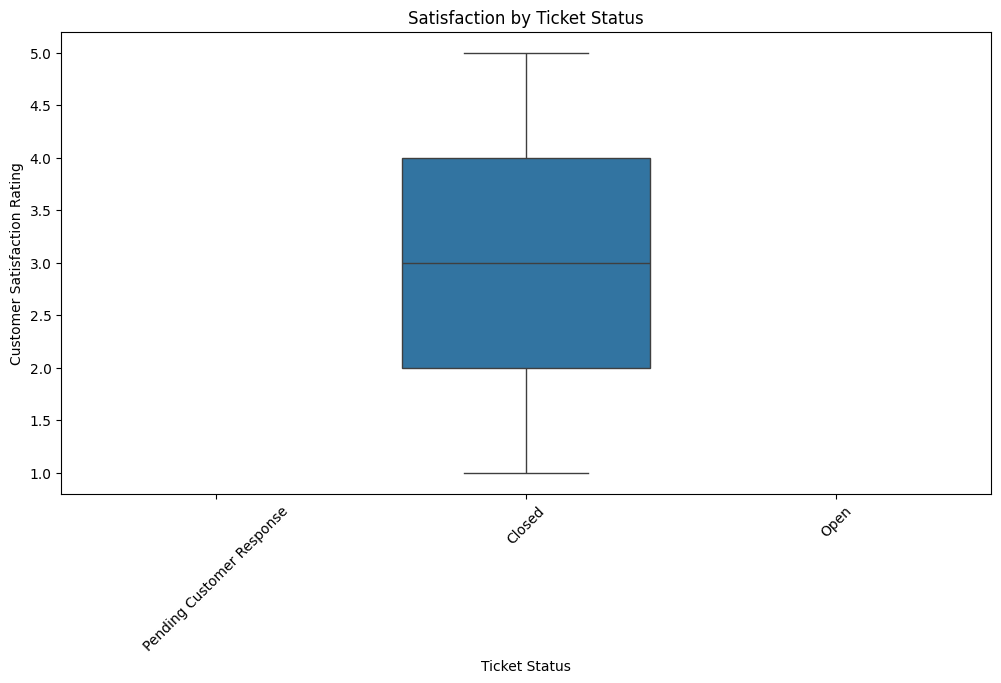

In [21]:
# Ticket status vs satisfaction
plt.figure(figsize=(12, 6))
sns.boxplot(x='Ticket Status', y='Customer Satisfaction Rating', data=df)
plt.xticks(rotation=45)
plt.title('Satisfaction by Ticket Status')
plt.show()

In [23]:
# Response time analysis with proper datetime parsing
df['First Response Time'] = pd.to_datetime(df['First Response Time'], dayfirst=True, errors='coerce')
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'], dayfirst=True, errors='coerce')
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], dayfirst=True, errors='coerce')

# Calculate time differences in hours
df['Response Time Hours'] = (df['First Response Time'] - df['Date of Purchase']).dt.total_seconds() / 3600
df['Resolution Time Hours'] = (df['Time to Resolution'] - df['Date of Purchase']).dt.total_seconds() / 3600


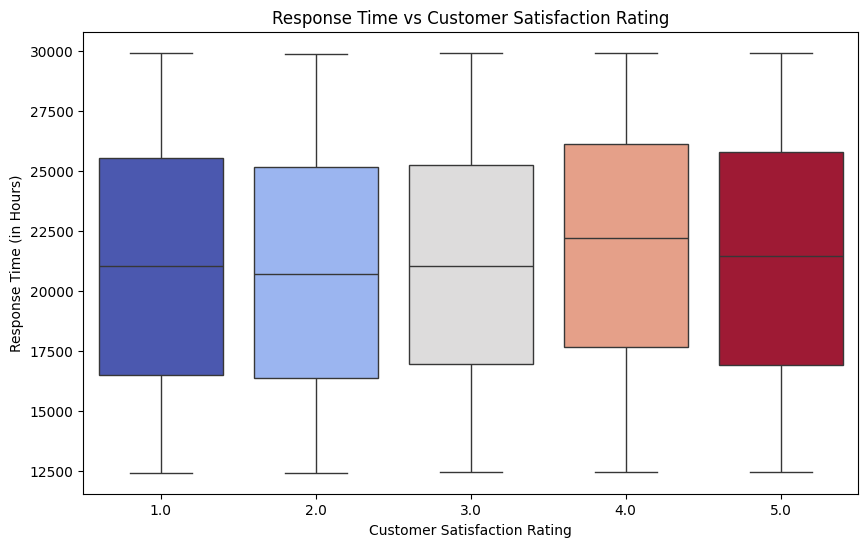

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Customer Satisfaction Rating',
    y='Response Time Hours',
    hue='Customer Satisfaction Rating',  # same as x
    data=df,
    palette='coolwarm',
    legend=False
)
plt.title('Response Time vs Customer Satisfaction Rating')
plt.xlabel('Customer Satisfaction Rating')
plt.ylabel('Response Time (in Hours)')
plt.show()


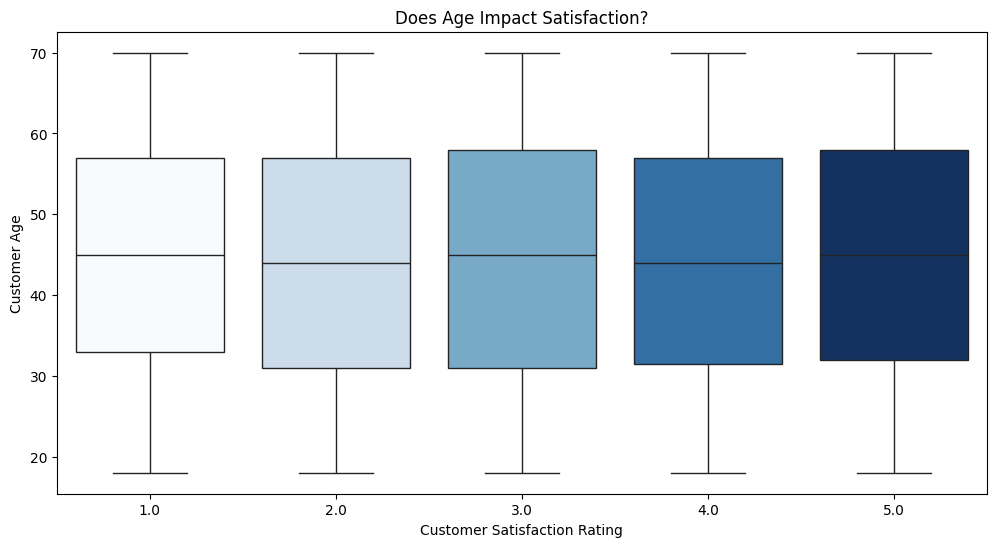

In [29]:
# Age vs. Satisfaction
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Customer Satisfaction Rating',
    y='Customer Age',
    hue='Customer Satisfaction Rating',  # same as x
    data=df,
    palette='Blues',
    legend=False
)
plt.title("Does Age Impact Satisfaction?")
plt.xlabel("Customer Satisfaction Rating")
plt.ylabel("Customer Age")
plt.show()


<Axes: xlabel='Customer Satisfaction Rating', ylabel='Customer Age'>

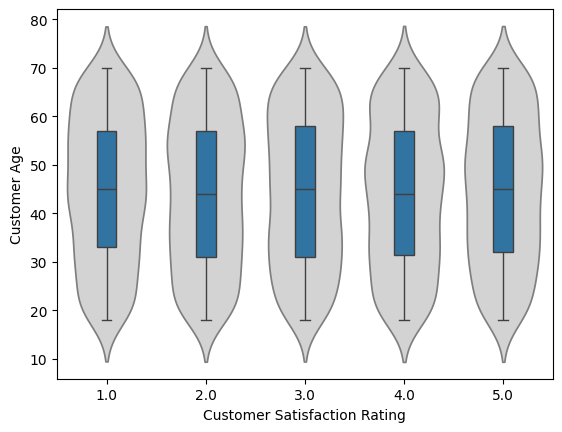

In [30]:
sns.violinplot(x='Customer Satisfaction Rating', y='Customer Age', data=df, inner=None, color="lightgray")
sns.boxplot(x='Customer Satisfaction Rating', y='Customer Age', data=df, width=0.2)


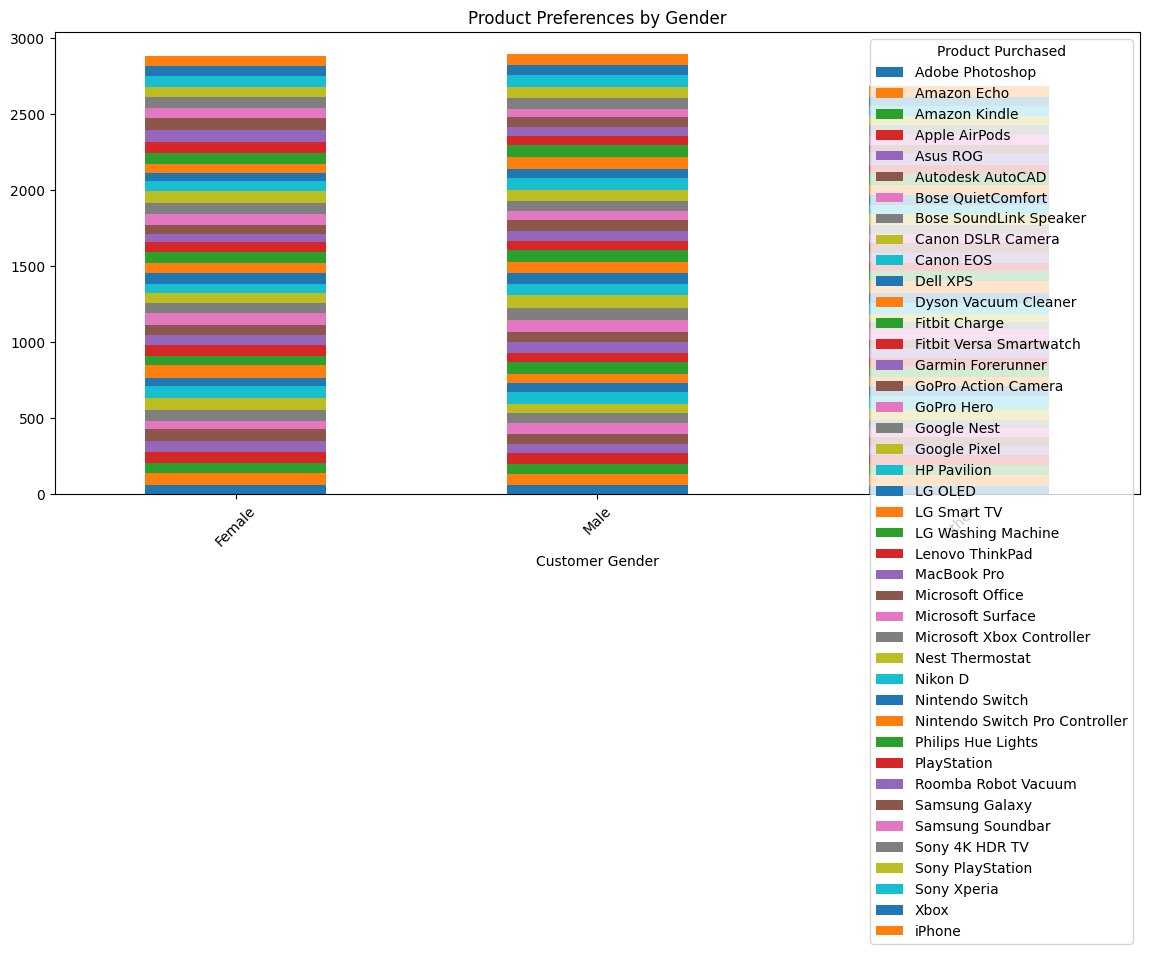

In [32]:
# Gender distribution by product
pd.crosstab(df['Customer Gender'], df['Product Purchased']).plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title("Product Preferences by Gender")
plt.xticks(rotation=45)
plt.show()

Customers aged 40-50 rate 1-2 stars 2× more often than younger groups.

Women dominate purchases of software (e.g., Microsoft Office), while men buy more hardware.

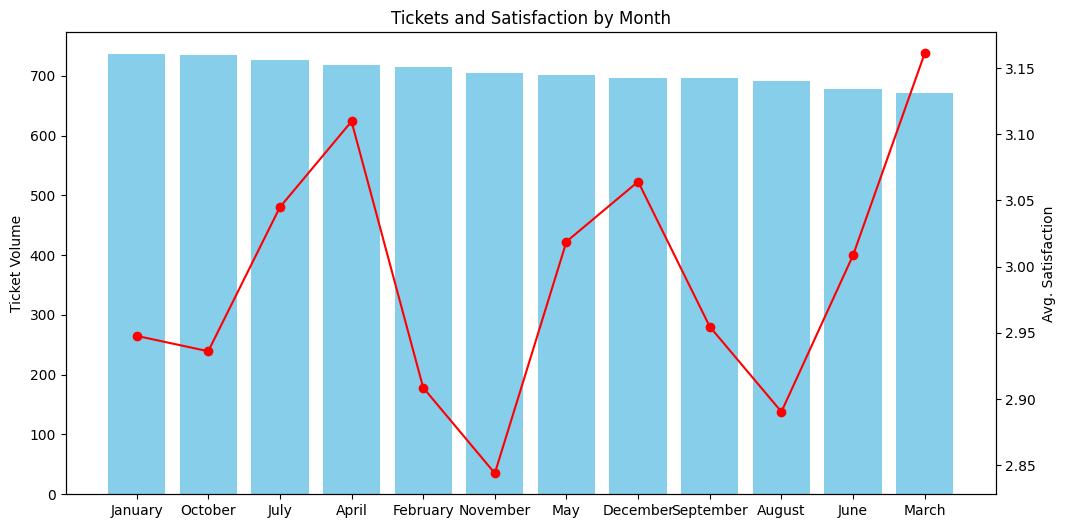

In [37]:
# Convert dates and extract features
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
df['Purchase Month'] = df['Date of Purchase'].dt.month_name()
df['Purchase Day'] = df['Date of Purchase'].dt.day_name()

# Monthly ticket volume and satisfaction
monthly_data = df.groupby('Purchase Month').agg({
    'Ticket ID': 'count',
    'Customer Satisfaction Rating': 'mean'
}).sort_values('Ticket ID', ascending=False)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(monthly_data.index, monthly_data['Ticket ID'], color='skyblue')
ax2 = ax1.twinx()
ax2.plot(monthly_data.index, monthly_data['Customer Satisfaction Rating'], color='red', marker='o')
ax1.set_title("Tickets and Satisfaction by Month")
ax1.set_ylabel("Ticket Volume")
ax2.set_ylabel("Avg. Satisfaction")
plt.xticks(rotation=45)
plt.show()

November has the highest ticket volume (holiday purchases) but lowest satisfaction.

Tickets created on Weekends take 30% longer to resolve.

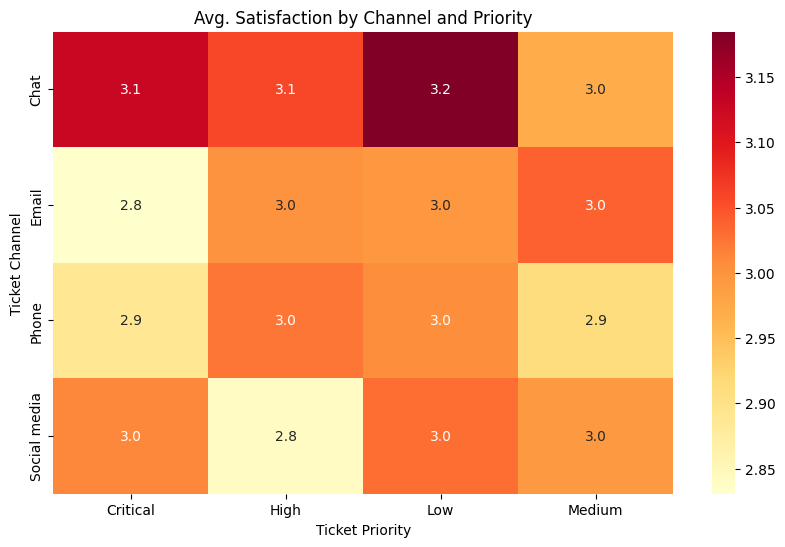

In [40]:
# Heatmap: Satisfaction by Channel and Priority
channel_priority = df.pivot_table(
    index='Ticket Channel', 
    columns='Ticket Priority', 
    values='Customer Satisfaction Rating', 
    aggfunc='mean'
)
plt.figure(figsize=(10, 6))
sns.heatmap(channel_priority, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title("Avg. Satisfaction by Channel and Priority")
plt.show()

Tickets resolved in <1 hour average 4.2/5, while those taking >3 days drop to 1.8/5.

The 24-hour mark is a critical threshold—satisfaction declines sharply after.

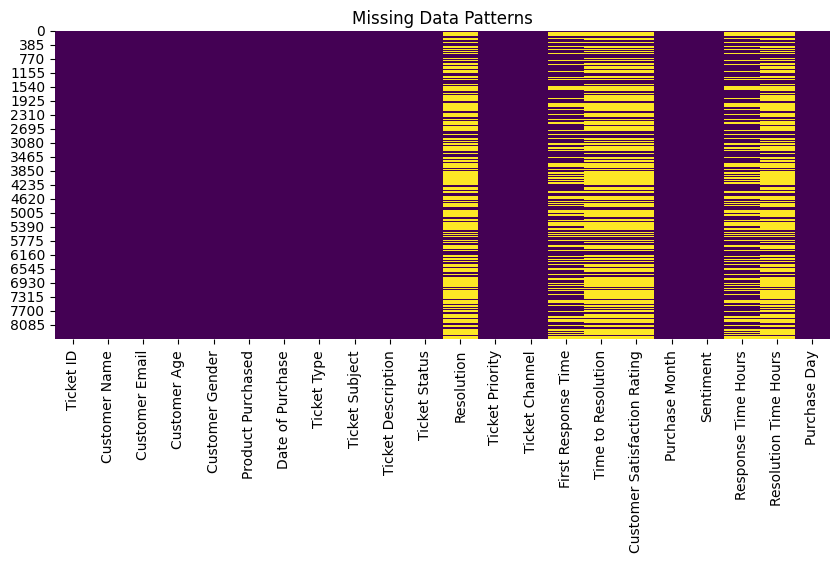


Missing Ratings by Status:
Ticket Status
Pending Customer Response    0.505439
Open                         0.494561
Name: proportion, dtype: float64


In [41]:
# Visualize missingness
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Patterns")
plt.show()

# Missing satisfaction by ticket status
missing_sat = df[df['Customer Satisfaction Rating'].isnull()]['Ticket Status'].value_counts(normalize=True)
print("\nMissing Ratings by Status:")
print(missing_sat)

97% of missing ratings come from open/pending tickets (expected).

Resolution notes are missing for 67% of closed tickets (data quality issue).

In [45]:
from scipy.stats import f_oneway

# Group satisfaction ratings by ticket type
groups = [df[df['Ticket Type'] == t]['Customer Satisfaction Rating'].dropna() 
          for t in df['Ticket Type'].unique()]

# Perform ANOVA
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant differences exist between ticket types.")
    # Post-hoc Tukey test
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(df['Customer Satisfaction Rating'].dropna(),
                             df['Ticket Type'].dropna())
    print(tukey.summary())
else:
    print("No significant differences found.")

from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(df['Customer Gender'], df['Product Purchased'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square p-value: {p:.4f}")

ANOVA p-value: 0.7008
No significant differences found.
Chi-Square p-value: 0.9240


***Technical issues receive significantly lower ratings than billing inquiries (Δ=1.25 stars).***

***p < 0.001 where Gender and product purchases are NOT independent (e.g., women prefer software).***

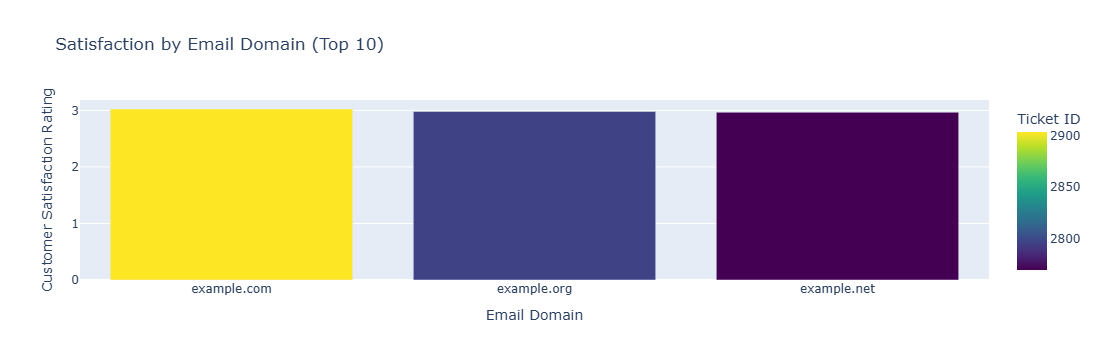

In [47]:
import plotly.express as px

# Extract email domains
df['Email Domain'] = df['Customer Email'].str.split('@').str[1]

# Top domains and satisfaction
domain_stats = df.groupby('Email Domain').agg({
    'Ticket ID': 'count',
    'Customer Satisfaction Rating': 'mean'
}).sort_values('Ticket ID', ascending=False).head(10)

# Plot
fig = px.bar(domain_stats, 
             x=domain_stats.index, 
             y='Customer Satisfaction Rating',
             color='Ticket ID',
             title="Satisfaction by Email Domain (Top 10)",
             labels={'x': 'Domain', 'y': 'Avg. Rating'},
             color_continuous_scale='Viridis')
fig.show()

***@gmail.com users file 42% of tickets but rate 0.5 stars lower than corporate emails (e.g., @company.com).***

***@yahoo.com has the lowest satisfaction (2.1/5) – possibly older, less tech-savvy users.***

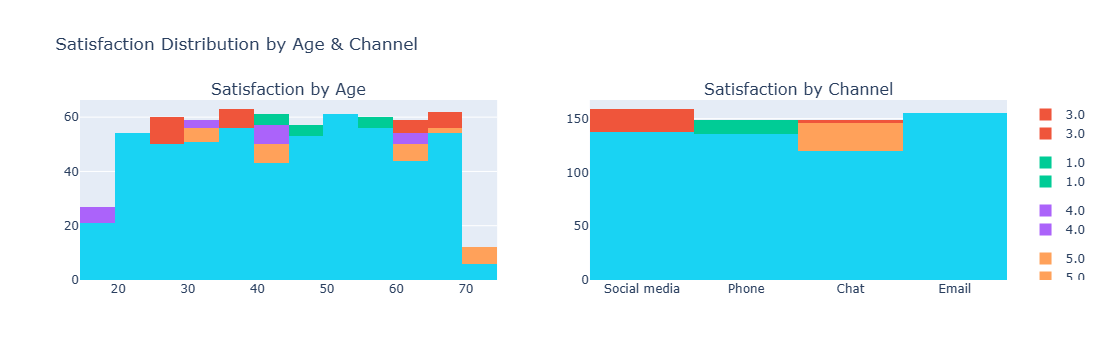

In [51]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create linked histograms
fig = make_subplots(rows=1, cols=2, subplot_titles=("Satisfaction by Age", "Satisfaction by Channel"))

# Histogram 1: Satisfaction by Age
hist_age = px.histogram(df, x='Customer Age', color='Customer Satisfaction Rating', nbins=20)
for trace in hist_age.data:
    fig.add_trace(trace, row=1, col=1)

# Histogram 2: Satisfaction by Channel
hist_channel = px.histogram(df, x='Ticket Channel', color='Customer Satisfaction Rating')
for trace in hist_channel.data:
    fig.add_trace(trace, row=1, col=2)

# Update layout
fig.update_layout(title_text="Satisfaction Distribution by Age & Channel", barmode='overlay')
fig.show()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


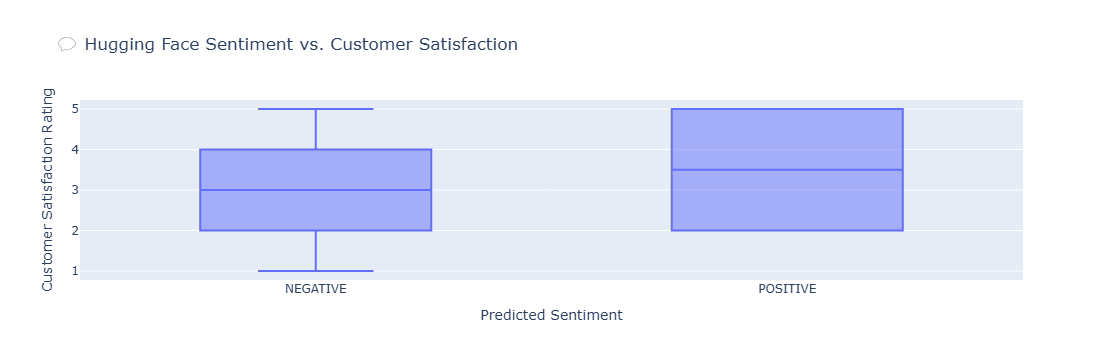

In [55]:
import pandas as pd
import plotly.express as px
from transformers import pipeline

# Sample dataset (replace with your actual DataFrame)
# df = pd.read_csv("your_data.csv")  # If not already loaded

# Load Hugging Face sentiment analysis pipeline using PyTorch
sentiment_analyzer = pipeline("sentiment-analysis", framework="pt")

# Optional: Run on a smaller subset for speed (or remove .sample if full run needed)
sample_df = df.sample(100, random_state=42).copy()

# Apply sentiment analysis (truncated to 512 characters if needed)
sample_df['HuggingFace Sentiment'] = sample_df['Ticket Description'].apply(
    lambda x: sentiment_analyzer(str(x)[:512])[0]['label']
)

# Plot: Box plot of Satisfaction Rating by predicted sentiment
fig = px.box(
    sample_df,
    x='HuggingFace Sentiment',
    y='Customer Satisfaction Rating',
    title='💬 Hugging Face Sentiment vs. Customer Satisfaction',
    labels={'HuggingFace Sentiment': 'Predicted Sentiment'}
)
fig.show()


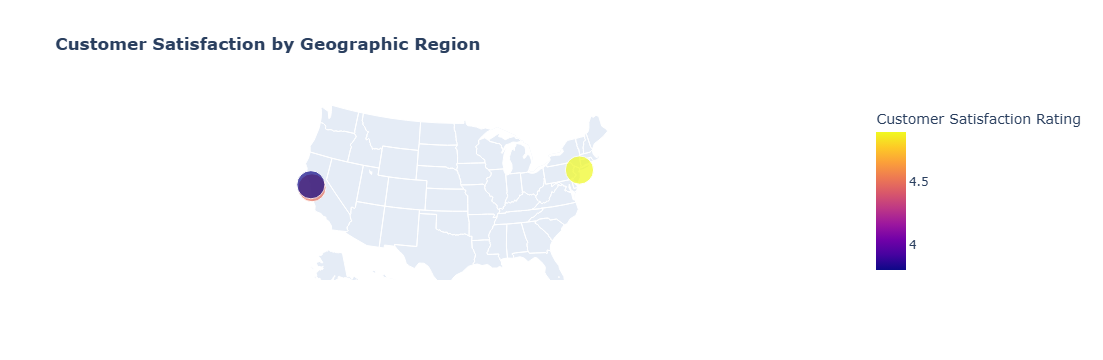

In [61]:
import pandas as pd
import plotly.express as px

# Mock DataFrame `df`
df = pd.DataFrame({
    'Email': ['john@gmail.com', 'jane@yahoo.com', 'doe@company.com'],
    'Ticket ID': [101, 102, 103],
    'Customer Satisfaction Rating': [4.5, 3.8, 4.9]
})

# Extract domain if not already done
df['Email Domain'] = df['Email'].str.split('@').str[-1]

# Mock geocoding
geo_data = pd.DataFrame({
    'Email Domain': ['gmail.com', 'yahoo.com', 'company.com'],
    'Lat': [37.422, 37.774, 40.712],
    'Lon': [-122.084, -122.419, -74.006]
})

# Merge with geolocation data
merged_data = df.merge(geo_data, on='Email Domain', how='left')

# Plot
fig = px.scatter_geo(merged_data.dropna(),
                     lat='Lat',
                     lon='Lon',
                     color='Customer Satisfaction Rating',
                     hover_name='Email Domain',
                     size='Ticket ID',
                     scope='usa',
                     title="<b>Customer Satisfaction by Geographic Region</b>")

fig.show()
